In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load test data
sampled_df = pd.read_csv(r'C:\Users\sagar\OneDrive\Desktop\Sem 3\Deep Learning\Project Roberta\to_Transformer_Train2.csv')

In [2]:
sampled_df

,Unnamed: 0.1,Unnamed: 0,text,source,label,sentences
0,0,0,I'm not happy with what I've wrote to be hones...,Human,0,['i am not happy with what i have wrote to be ...
1,1,1,Postmodernist Anthropology and its Impact on T...,Human,0,['postmodernist anthropology and its impact on...
2,2,2,"Firstly, is it okay to write an essay or does ...",Human,0,"['firstly, is it okay to write an essay or doe..."
3,3,3,Nissan Company’s Operational Changes and Manag...,Human,0,['nissan company’s operational changes and man...
4,4,4,I think some people might find visiting a nati...,Human,0,['i think some people might find visiting a na...
...,...,...,...,...,...,...
49995,49995,49995,The exploration of space has always captivated...,GPT-3.5,1,['the exploration of space has always captivat...
49996,49996,49996,"Famous people, whether they are actors, athlet...",GPT-3.5,1,"['famous people, whether they are actors, athl..."
49997,49997,49997,The future of 3D printing and its applications...,GPT-3.5,1,['the future of 3d printing and its applicatio...
49998,49998,49998,The world is currently facing a critical issue...,GPT-3.5,1,['the world is currently facing a critical iss...


In [3]:
# import torch
# from transformers import RobertaForSequenceClassification

# Path to your saved model checkpoint
checkpoint_path = './model_checkpoints_Roberta_Venkat/checkpoint_epoch_3.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Extract the state dictionary that corresponds to the model
model_state_dict = checkpoint['model_state_dict']

tokenizer = RobertaTokenizer.from_pretrained('./model_checkpoints_finetune')
# Initialize the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)
model.eval()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [4]:
# # Load the tokenizer and model
# model_path = './model_checkpoints'  # Adjust to where your model checkpoint is saved
# tokenizer = RobertaTokenizer.from_pretrained(model_path)
# model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=2)
# model.eval()
# model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [5]:
# Tokenize the test dataset
def prepare_data(texts, tokenizer, max_length=512):
    encoding = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
    return encoding

In [6]:
from tqdm import tqdm
predictions = []
probabilities = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for index, row in tqdm(sampled_df.iterrows()):
    input_ids = tokenizer(row['sentences'], truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    
    # Move input_ids tensor to the same device as the model
    input_ids = {key: value.to(device) for key, value in input_ids.items()}

    true_label = torch.tensor(row['label']).to(device)
    
    with torch.no_grad():
        outputs = model(**input_ids)
        logits = outputs.logits
        
        # Move logits tensor to CPU and then convert it to a NumPy array
        logits_cpu = logits.to('cpu')
        probs = torch.nn.functional.softmax(logits_cpu, dim=-1).numpy()
        
        # Deallocate GPU memory
        del logits, logits_cpu
        
        predictions.append(probs.argmax(axis=-1)[0])
        probabilities.append(probs[0, 1])  # Storing the probability of the positive class
        
        

50000it [12:54, 64.52it/s]


In [7]:
# Store predictions and probabilities in the DataFrame
sampled_df['predictions'] = predictions
sampled_df['probabilities'] = probabilities

In [8]:
# Calculate accuracy of the predictions
actual_labels = sampled_df['label'].values
accuracy = accuracy_score(actual_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9751


In [9]:
from sklearn.metrics import confusion_matrix, f1_score
f1score = f1_score(sampled_df['label'].values, sampled_df['predictions'], average='weighted')
print(f1score)

0.9751087282763387


In [10]:
from sklearn.metrics import log_loss
import numpy as np
# Assuming test_df['predictions'] and test_df['label'] are NumPy arrays or lists
predictions = sampled_df['predictions']  # Predicted probabilities
labels = sampled_df['label']  # True labels

# Ensure predictions are probabilities between 0 and 1
predictions = np.clip(predictions, 1e-15, 1 - 1e-15)

# Calculate binary cross-entropy loss
binary_cross_entropy_loss = log_loss(labels, predictions)

print("Binary Cross-Entropy Loss:", binary_cross_entropy_loss)

Binary Cross-Entropy Loss: 0.8967660963212349


C:\Users\sagar\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)
C:\Users\sagar\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*

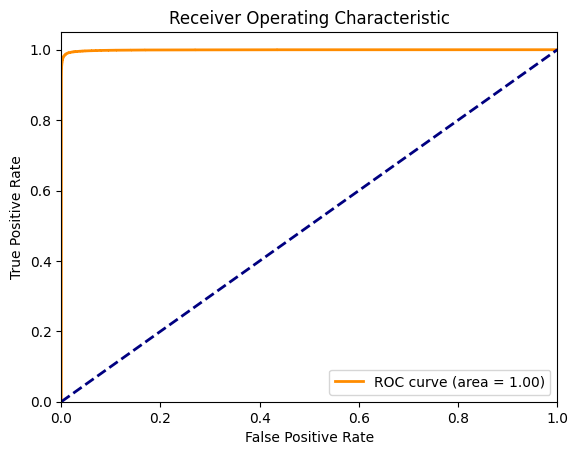

In [11]:

# Compute and plot the ROC curve
fpr, tpr, _ = roc_curve(actual_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [36]:
# import pandas as pd
# import torch
# from torch.utils.data import Dataset, DataLoader
# from transformers import RobertaTokenizer, RobertaForSequenceClassification
# from sklearn.metrics import accuracy_score, roc_curve, auc
# import matplotlib.pyplot as plt

# # Load test data
# test_df = pd.read_csv("V:\\deep_learning\\Project\\Test\\to_test.csv")
# sampled_df = test_df.sample(n=100, random_state=42)

# # Load the tokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # Initialize the model with the correct configuration and number of labels
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# import torch
# from transformers import RobertaForSequenceClassification

# # Path to your saved model checkpoint
# checkpoint_path = './model_checkpoints/checkpoint_epoch_3.pth'

# # Load the checkpoint
# checkpoint = torch.load(checkpoint_path)

# # Extract the state dictionary that corresponds to the model
# model_state_dict = checkpoint['model_state_dict']

# # Initialize the model
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# # Load the state dictionary into the model
# model.load_state_dict(model_state_dict)
# model.eval()
# model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [38]:

# # Print out the parameter settings to verify which are trainable or frozen
# for name, param in model.named_parameters():
#     print(f"{name} is {'trainable' if param.requires_grad else 'frozen'}")

roberta.embeddings.word_embeddings.weight is trainable
roberta.embeddings.position_embeddings.weight is trainable
roberta.embeddings.token_type_embeddings.weight is trainable
roberta.embeddings.LayerNorm.weight is trainable
roberta.embeddings.LayerNorm.bias is trainable
roberta.encoder.layer.0.attention.self.query.weight is trainable
roberta.encoder.layer.0.attention.self.query.bias is trainable
roberta.encoder.layer.0.attention.self.key.weight is trainable
roberta.encoder.layer.0.attention.self.key.bias is trainable
roberta.encoder.layer.0.attention.self.value.weight is trainable
roberta.encoder.layer.0.attention.self.value.bias is trainable
roberta.encoder.layer.0.attention.output.dense.weight is trainable
roberta.encoder.layer.0.attention.output.dense.bias is trainable
roberta.encoder.layer.0.attention.output.LayerNorm.weight is trainable
roberta.encoder.layer.0.attention.output.LayerNorm.bias is trainable
roberta.encoder.layer.0.intermediate.dense.weight is trainable
roberta.encode

In [39]:
# # Freeze all parameters first
# for param in model.parameters():
#     param.requires_grad = False

# # Set the last two layers of the encoder and the classifier to be trainable
# layer_indices = [10, 11]  # The last two layers

# for i, layer in enumerate(model.roberta.encoder.layer):
#     if i in layer_indices:
#         for param in layer.parameters():
#             param.requires_grad = True

# # Make classifier layer trainable
# for param in model.classifier.parameters():
#     param.requires_grad = True

# # Verify which parameters are trainable
# for name, param in model.named_parameters():
#     print(f"{name} is {'trainable' if param.requires_grad else 'frozen'}")

roberta.embeddings.word_embeddings.weight is frozen
roberta.embeddings.position_embeddings.weight is frozen
roberta.embeddings.token_type_embeddings.weight is frozen
roberta.embeddings.LayerNorm.weight is frozen
roberta.embeddings.LayerNorm.bias is frozen
roberta.encoder.layer.0.attention.self.query.weight is frozen
roberta.encoder.layer.0.attention.self.query.bias is frozen
roberta.encoder.layer.0.attention.self.key.weight is frozen
roberta.encoder.layer.0.attention.self.key.bias is frozen
roberta.encoder.layer.0.attention.self.value.weight is frozen
roberta.encoder.layer.0.attention.self.value.bias is frozen
roberta.encoder.layer.0.attention.output.dense.weight is frozen
roberta.encoder.layer.0.attention.output.dense.bias is frozen
roberta.encoder.layer.0.attention.output.LayerNorm.weight is frozen
roberta.encoder.layer.0.attention.output.LayerNorm.bias is frozen
roberta.encoder.layer.0.intermediate.dense.weight is frozen
roberta.encoder.layer.0.intermediate.dense.bias is frozen
robe

In [40]:


# # Tokenize the test dataset
# def prepare_data(texts, tokenizer, max_length=512):
#     encoding = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
#     return encoding

# predictions = []
# probabilities = []

In [41]:


# # Iterate over sampled data to predict and collect probabilities
# for index, row in sampled_df.iterrows():
#     encoded_input = prepare_data(row['sentences'], tokenizer)
#     encoded_input = {key: value.to(model.device) for key, value in encoded_input.items()}
    
#     with torch.no_grad():
#         outputs = model(**encoded_input)
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()
#         predictions.append(probs.argmax(axis=-1)[0])
#         probabilities.append(probs[0, 1])

# # Store predictions and probabilities in the DataFrame
# sampled_df['predictions'] = predictions
# sampled_df['probabilities'] = probabilities

# # Calculate accuracy of the predictions
# actual_labels = sampled_df['label'].values
# accuracy = accuracy_score(actual_labels, predictions)
# print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8900
